<a href="https://colab.research.google.com/github/JunTogo/sample_ai_app/blob/main/section_4/01_train_model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデルの訓練
画像識別アプリで使用する、オリジナルのCNNモデルを訓練し保存します。  
今回は訓練データにCIFAR-10を使用します。  


## CIFAR-10
torchvision.datasetsを使い、CIFAR-10を読み込みます。  
CIFARは、約6万枚の画像にラベルをつけたたデータセットです。  
以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示します。

Files already downloaded and verified
データの数: 10000


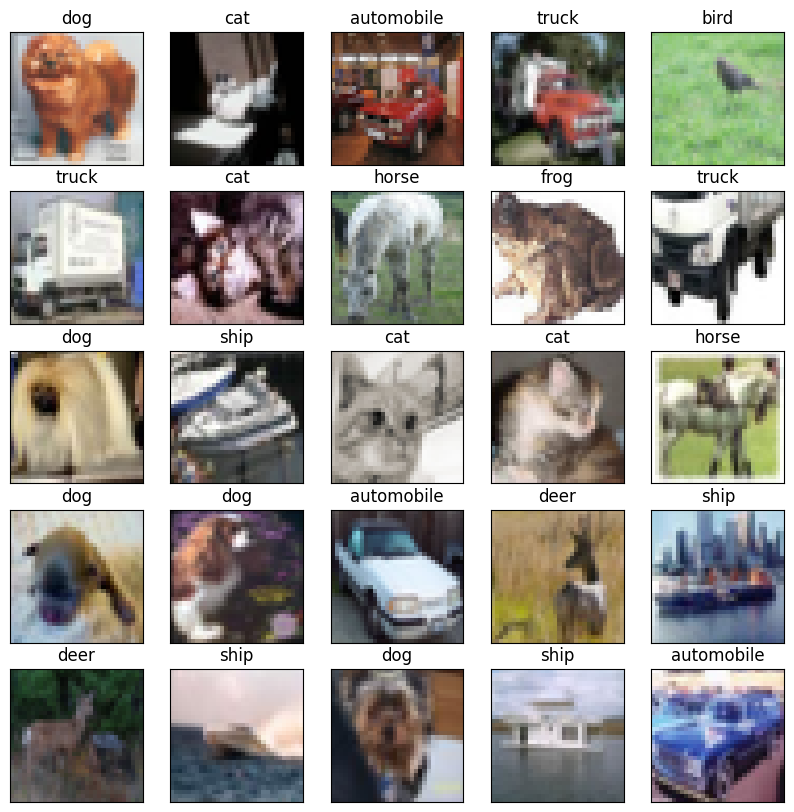

In [9]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transforms.ToTensor())
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = next(dataiter)  # 最初のバッチを取り出す

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
CIFAR-10を読み込んで、データ拡張とともにDataLoaderの設定を行います。  

In [10]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、CNNのモデルを構築します。   

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.3)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。   
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [12]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = next(iter(test_loader))
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.7893459424948144 Loss_Test: 1.514920949935913
Epoch: 1 Loss_Train: 1.553728590078671 Loss_Test: 1.4107835292816162
Epoch: 2 Loss_Train: 1.4758653588916943 Loss_Test: 1.3480364084243774
Epoch: 3 Loss_Train: 1.4181172504754322 Loss_Test: 1.2901471853256226
Epoch: 4 Loss_Train: 1.3811025462492044 Loss_Test: 1.2641161680221558
Epoch: 5 Loss_Train: 1.3399155485203198 Loss_Test: 1.2196707725524902
Epoch: 6 Loss_Train: 1.3164835482302224 Loss_Test: 1.2115492820739746
Epoch: 7 Loss_Train: 1.297244700248284 Loss_Test: 1.2563912868499756
Epoch: 8 Loss_Train: 1.2794451077118554 Loss_Test: 1.1823469400405884
Epoch: 9 Loss_Train: 1.2627784359028271 Loss_Test: 1.148551344871521
Epoch: 10 Loss_Train: 1.2441406153961825 Loss_Test: 1.1426188945770264
Epoch: 11 Loss_Train: 1.2349308717738636 Loss_Test: 1.1132194995880127
Epoch: 12 Loss_Train: 1.2228808999823793 Loss_Test: 1.1102572679519653
Epoch: 13 Loss_Train: 1.2149824975701549 Loss_Test: 1.1552472114562988
Epoch: 14 Loss_Train

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

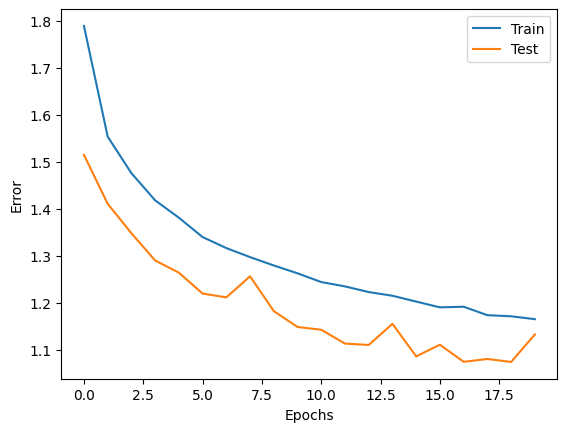

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [14]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 59.830000000000005%


## モデルの保存
訓練済みモデルのパラメータを保存します。    
`state_dict()`によりモデルの各パラメータが取得できるので、これを保存します。

In [15]:
import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "model_cnn.pth")

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[ 0.0796, -0.0285,  0.0424,  0.0280,  0.0189],
         [ 0.0490,  0.0104, -0.0745, -0.0316,  0.0282],
         [-0.0363,  0.0022, -0.0709, -0.0022, -0.0672],
         [ 0.0914, -0.1151, -0.1367, -0.0965, -0.1674],
         [-0.0853,  0.0140, -0.0578, -0.1865, -0.0712]],

        [[-0.0509,  0.0316, -0.0157,  0.0068,  0.0263],
         [-0.0562, -0.0434,  0.0062,  0.0693, -0.0465],
         [-0.0308, -0.0245,  0.0531,  0.0825, -0.0871],
         [-0.0327,  0.0506, -0.0816,  0.0750, -0.0180],
         [ 0.1004, -0.1083,  0.0202, -0.0660, -0.0219]],

        [[-0.1071, -0.0653,  0.1366,  0.1064,  0.1105],
         [ 0.0751,  0.1541,  0.2227,  0.1140,  0.1125],
         [ 0.0089,  0.1180,  0.1187,  0.1668,  0

## モデルの読み込み
保存したパラメータを読み込み、モデルに設定します。  
`torch.load()`で`map_location`にCPUを指定することで、GPUで訓練したモデルをCPUで使用することが可能になります。  


In [16]:
# 読み込み
net_loaded = Net()
net_loaded.load_state_dict(torch.load("model_cnn.pth", map_location=torch.device("cpu")))  #CPU対応
net_loaded.eval()  # 評価モード

# state_dict()の表示
for key in net_loaded.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net_loaded.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[ 0.0796, -0.0285,  0.0424,  0.0280,  0.0189],
         [ 0.0490,  0.0104, -0.0745, -0.0316,  0.0282],
         [-0.0363,  0.0022, -0.0709, -0.0022, -0.0672],
         [ 0.0914, -0.1151, -0.1367, -0.0965, -0.1674],
         [-0.0853,  0.0140, -0.0578, -0.1865, -0.0712]],

        [[-0.0509,  0.0316, -0.0157,  0.0068,  0.0263],
         [-0.0562, -0.0434,  0.0062,  0.0693, -0.0465],
         [-0.0308, -0.0245,  0.0531,  0.0825, -0.0871],
         [-0.0327,  0.0506, -0.0816,  0.0750, -0.0180],
         [ 0.1004, -0.1083,  0.0202, -0.0660, -0.0219]],

        [[-0.1071, -0.0653,  0.1366,  0.1064,  0.1105],
         [ 0.0751,  0.1541,  0.2227,  0.1140,  0.1125],
         [ 0.0089,  0.1180,  0.1187,  0.1668,  0

<ipython-input-16-80c2c476708d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded.load_state_dict(torch.load("model_cnn.pth", map_location=torch.device("cpu")))  #

モデルの各パラメータを保存し、読み込むことができました。  
「model_cnn.pth」をローカルにダウンロードしておきましょう。  
後ほどGitHubのレポジトリにアップします。